In [1]:
from dataclasses import dataclass
import pandas as pd
import scipy.stats as stats
import numpy as np
from sklearn.model_selection import train_test_split as sklearn_train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import altair as alt
alt.renderers.enable('svg')

RendererRegistry.enable('svg')

In [2]:
# First lets load our data
df = pd.read_parquet('data/abalone_processed.parquet')

In [3]:
# Take a quick look at the data
df.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,age_group
0,0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,Class 3: 11-15 Years
1,0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,Class 1: 0-7 Years
2,1,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,Class 2: 8-10 Years
3,0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,Class 2: 8-10 Years
4,2,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,Class 1: 0-7 Years


In [4]:
# Form our X and y variables
df_X = df.drop(columns=['rings', 'age_group'])
df_y = df['age_group']

## Fit a CART Model

In [5]:
# Helper functions
def train_test_split(df_X: pd.DataFrame, df_y: pd.DataFrame, test_size: float):
  return sklearn_train_test_split(df_X, df_y, test_size=test_size)

In [6]:
@dataclass
class CartResult:
  model: DecisionTreeClassifier
  df_X_train: pd.DataFrame
  df_X_test: pd.DataFrame
  df_y_train: pd.DataFrame
  df_y_test: pd.DataFrame
  f1_train: float
  f1_test: float

def cart(df_X: pd.DataFrame, df_y: pd.DataFrame, max_depth: int = None, ccp_alpha: float = 0.0):
  # First split the data into train and test sets
  df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_X, df_y, test_size=0.4)

  # Fit our model
  model = DecisionTreeClassifier(max_depth=max_depth, ccp_alpha=ccp_alpha).fit(df_X_train, df_y_train)

  # Make predictions for our training and testing sets
  df_y_train_pred = model.predict(df_X_train)
  df_y_test_pred = model.predict(df_X_test)

  # Now lets calculate the f1 score for both
  f1_train = f1_score(df_y_train, df_y_train_pred, average='weighted')
  f1_test = f1_score(df_y_test, df_y_test_pred, average='weighted')

  return CartResult(
    model=model,
    df_X_train=df_X_train,
    df_X_test=df_X_test,
    df_y_train=df_y_train,
    df_y_test=df_y_test,
    f1_train=f1_train,
    f1_test=f1_test,
  )

In [7]:
# Lets fit 10 CART models and see how they perform
results = []
for i in range(10):
  result = cart(df_X, df_y)
  results.append(result)

In [8]:
# Now lets calculate the mean f1 score and the confidence interval
f1_train_mean = np.mean([result.f1_train for result in results])
f1_test_mean = np.mean([result.f1_test for result in results])
f1_test_ci = stats.norm.interval(0.95, loc=f1_test_mean, scale=np.std([result.f1_test for result in results]))

print(f'f1_train_mean: {f1_train_mean}')
print(f'f1_test_mean: {f1_test_mean}')
print(f'f1_test_confidence_interval: {f1_test_ci}')

f1_train_mean: 1.0
f1_test_mean: 0.5338225915615815
f1_test_confidence_interval: (0.5166866197068232, 0.5509585634163399)


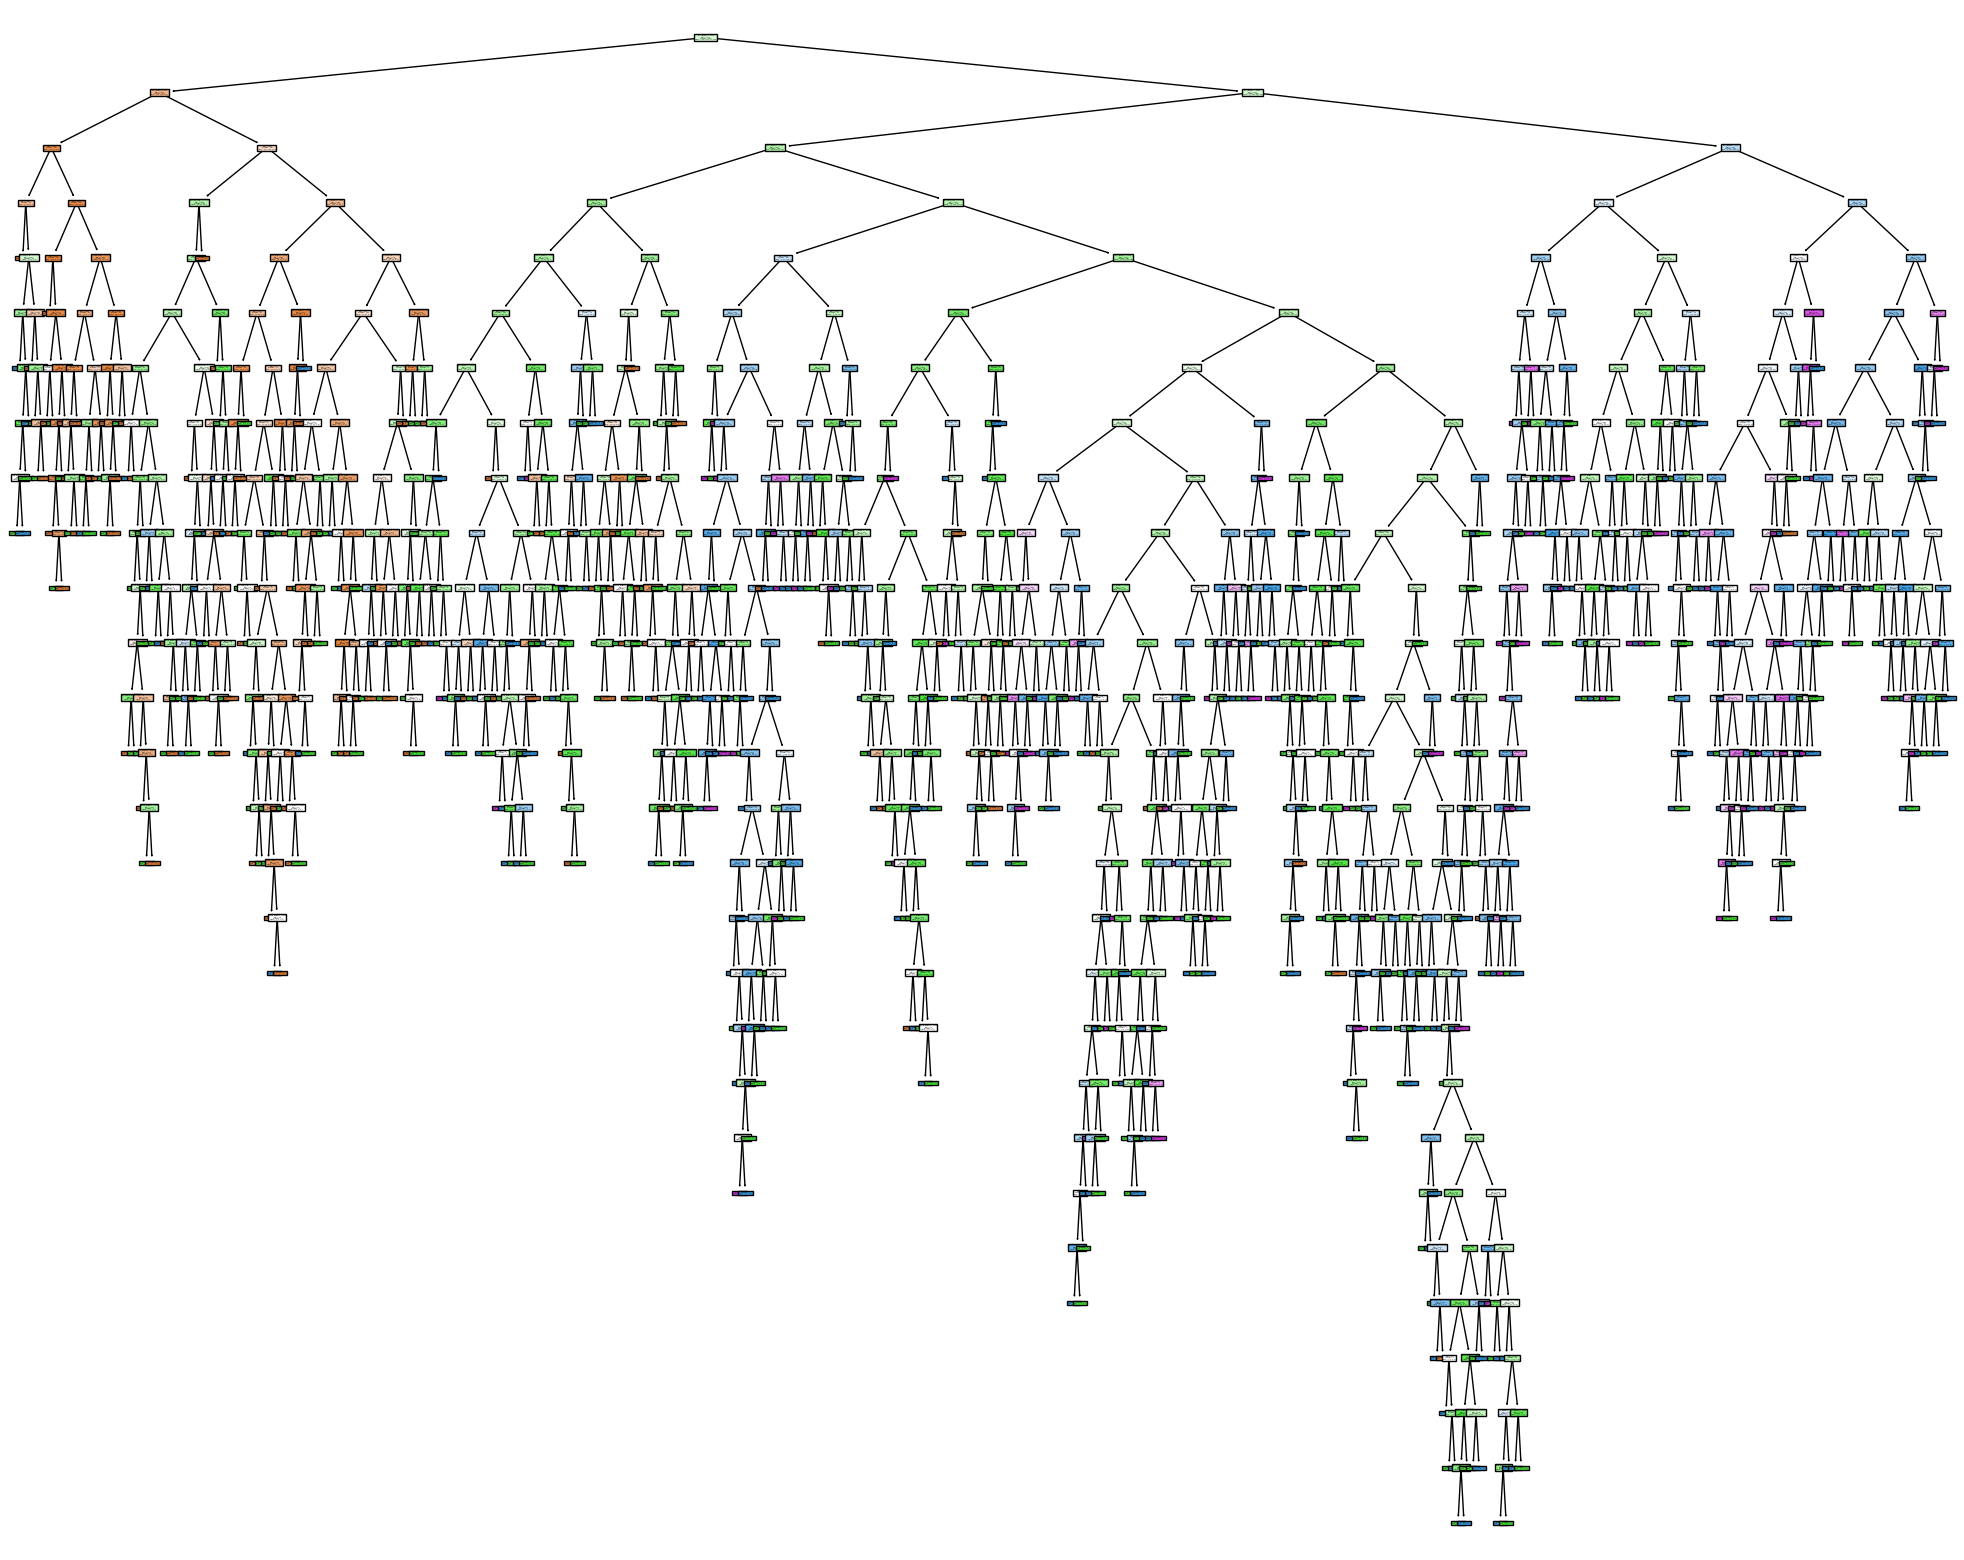

In [9]:
# Lets visualise one of these trees
fig = plt.figure(figsize=(25,20))
x = plot_tree(results[0].model, filled=True, feature_names=df_X.columns)
fig.savefig('assets/cart_tree_unrestricted.png')

In [10]:
print(f"Tree Depth: {results[0].model.get_depth()}, Tree Leaves: {results[0].model.get_n_leaves()}")

Tree Depth: 27, Tree Leaves: 710


In [11]:
# Lets fit a small CART model so we can visualise it
result = cart(df_X, df_y, max_depth=2)

In [12]:
print(f"Tree Depth: {result.model.get_depth()}, Tree Leaves: {result.model.get_n_leaves()}")

Tree Depth: 2, Tree Leaves: 4


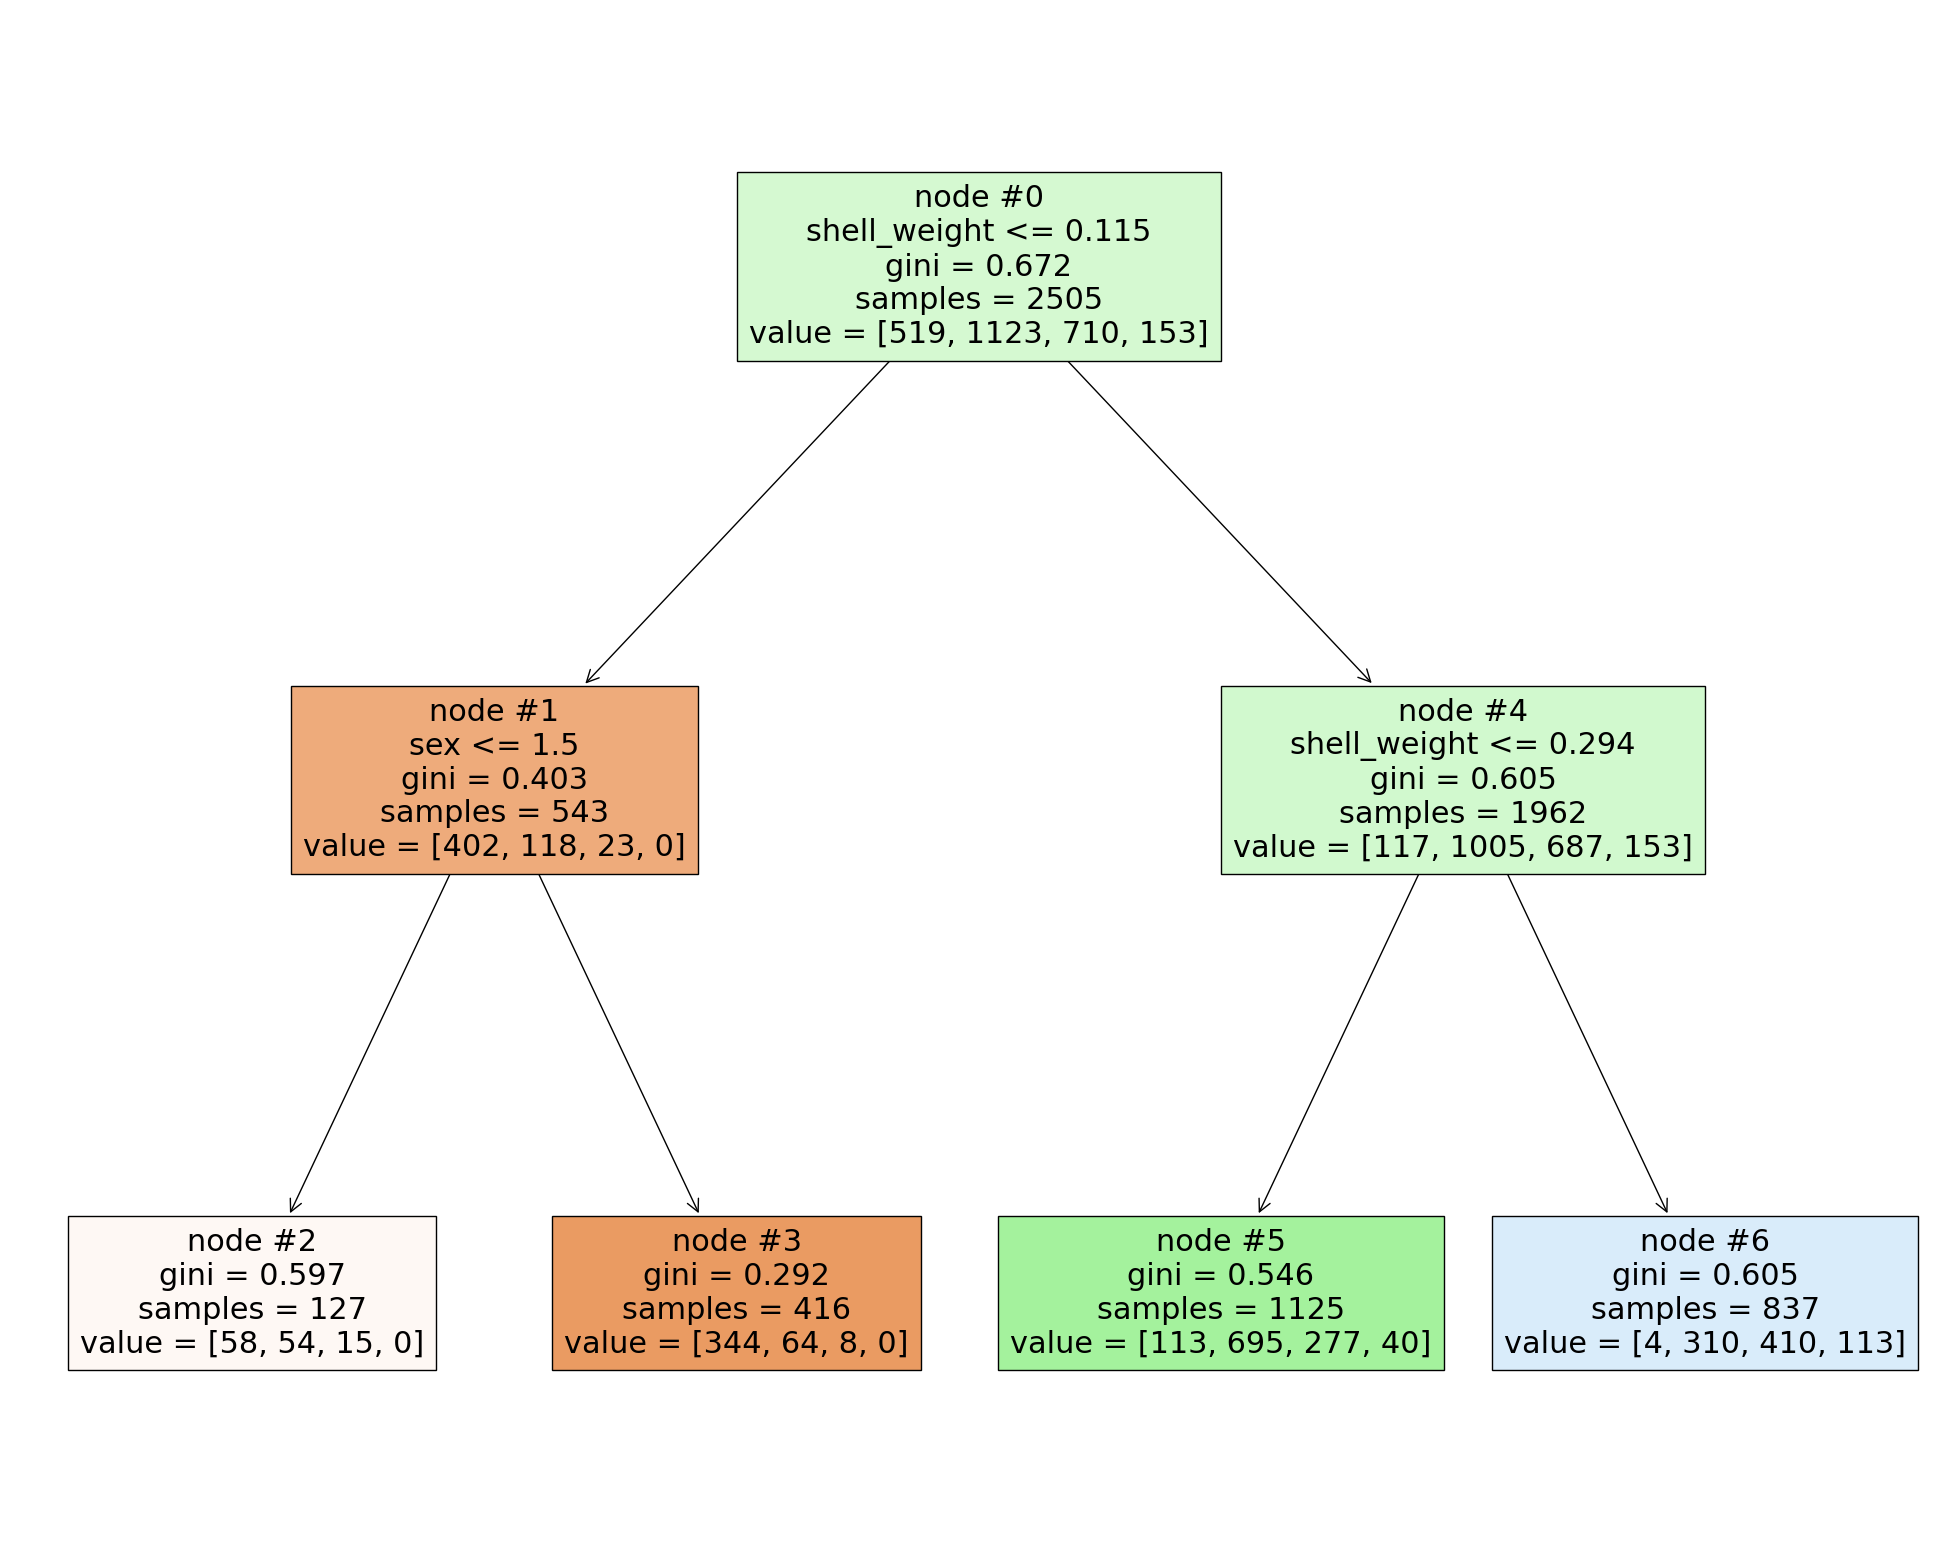

In [13]:
# Lets visualise one of these trees
fig = plt.figure(figsize=(25,20))
x = plot_tree(result.model, filled=True, node_ids=True, feature_names=df_X.columns)
fig.savefig('assets/cart_tree_smaller.png')

In [14]:
def predict(shell_weight):
  # Start at root Node 0
  if shell_weight <= 0.12:
    # Go to Node 1
    if shell_weight <= 0.067:
      # Go to Node 2
      # Return class 0 because that is the majority class that
      # made it to this particular node
      # as dictated by the value array = [222, 25, 4, 0]
      return 0
    else:
      # Go to Node 3
      # Return class 0 because that is the majority class
      # as dictated by the value array = [168, 108, 18, 0]
      return 0
  else:
    # Go to Node 4
    if shell_weight <= 0.335:
      # Go to Node 5
      # Return class 1 because that is the majority class that
      # made it to this particular node
      # as dictated by the value array = [109, 814, 362, 58]
      return 1
    else:
      # Go to Node 6
      # Return class 2 because that is the majority class that
      # made it to this particular node
      # as dictated by the value array = [4, 190, 326, 98]
      return 2

## Post Tree Pruning

In [15]:
# Fit a cart model without restricting the depth
result = cart(df_X, df_y)

# Generate the cost complexity pruning path
ccp_results = result.model.cost_complexity_pruning_path(result.df_X_train, result.df_y_train)

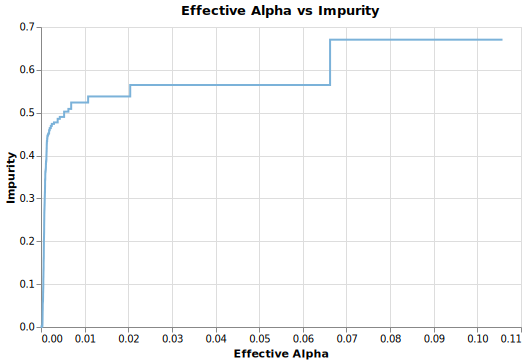

In [16]:
ccp_alpha_vs_impurities = alt.Chart(pd.DataFrame(ccp_results), title="Effective Alpha vs Impurity").mark_line(interpolate="step").encode(
  x=alt.X('ccp_alphas', axis=alt.Axis(title='Effective Alpha')),
  y=alt.Y('impurities', axis=alt.Axis(title='Impurity')),
  color=alt.ColorValue('#7BB2D9'),
).properties(
  width=480,
  height=300
)

ccp_alpha_vs_impurities.save('assets/ccp_alpha_vs_impurities.png', ppi=100)
ccp_alpha_vs_impurities

In [17]:
results = []

for ccp_alpha in ccp_results.ccp_alphas:
  results.append(cart(df_X=df_X, df_y=df_y, ccp_alpha=ccp_alpha))

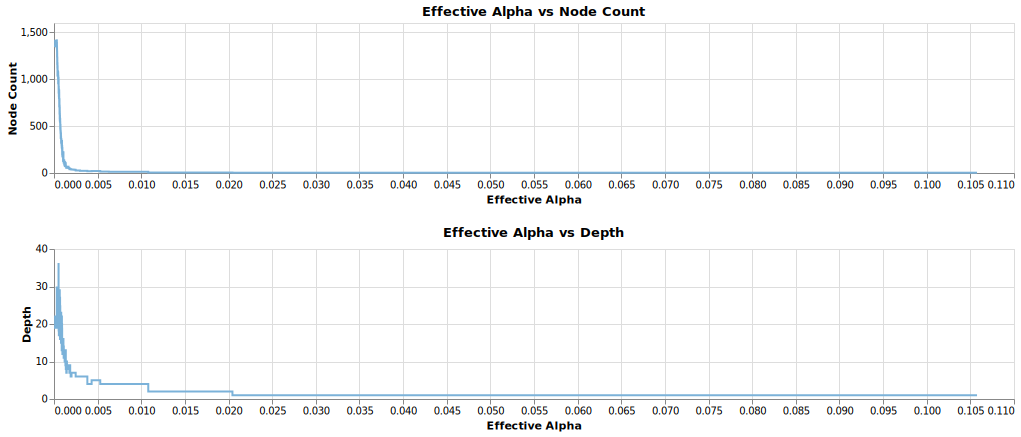

In [18]:
# Now let's take a look at how the alpha value impacts the number of nodes and depth of the tree
node_counts = [result.model.tree_.node_count for result in results]
depth = [result.model.tree_.max_depth for result in results]

ccp_results['node_count'] = node_counts
ccp_results['depth'] = depth

ccp_alpha_vs_node_count = alt.Chart(pd.DataFrame(ccp_results), title="Effective Alpha vs Node Count").mark_line(interpolate="step").encode(
  x=alt.X('ccp_alphas', axis=alt.Axis(title='Effective Alpha')),
  y=alt.Y('node_count', axis=alt.Axis(title='Node Count')),
  color=alt.ColorValue('#7BB2D9'),
).properties(
  width=960,
  height=150
)

ccp_alpha_vs_depth = alt.Chart(pd.DataFrame(ccp_results), title="Effective Alpha vs Depth").mark_line(interpolate="step").encode(
  x=alt.X('ccp_alphas', axis=alt.Axis(title='Effective Alpha')),
  y=alt.Y('depth', axis=alt.Axis(title='Depth')),
  color=alt.ColorValue('#7BB2D9'),
).properties(
  width=960,
  height=150
)

# ccp_alpha_vs_impurities.save('assets/ccp_alpha_vs_impurities.png', ppi=100)
(ccp_alpha_vs_node_count & ccp_alpha_vs_depth).save('assets/ccp_alpha_vs_node_count_and_depth.png', ppi=100)
(ccp_alpha_vs_node_count & ccp_alpha_vs_depth)

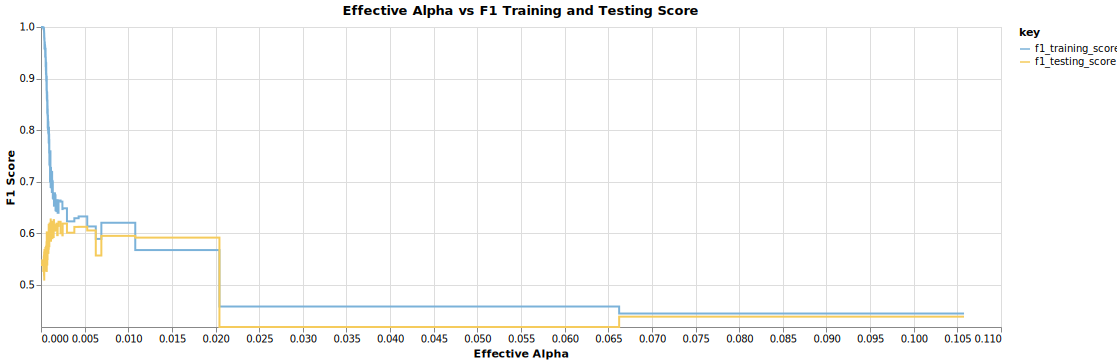

In [19]:
# Now let's see how this impacts our training and testing metrics
f1_training_scores = [result.f1_train for result in results]
f1_testing_scores = [result.f1_test for result in results]

ccp_results['f1_training_score'] = f1_training_scores
ccp_results['f1_testing_score'] = f1_testing_scores

# Get the lowest f1 score
lowest_f1_score = min(min(f1_training_scores), min(f1_testing_scores))

ccp_alpha_vs_f1_training_and_testing_score = alt.Chart(pd.DataFrame(ccp_results), title="Effective Alpha vs F1 Training and Testing Score").transform_fold(
  ['f1_training_score', 'f1_testing_score']
).mark_line(interpolate="step").encode(
  x=alt.X('ccp_alphas', axis=alt.Axis(title='Effective Alpha')),
  y=alt.Y('value:Q', axis=alt.Axis(title='F1 Score'), scale=alt.Scale(domain=[lowest_f1_score, 1.0])),
  color=alt.Color('key:N', scale=alt.Scale(domain=['f1_training_score', 'f1_testing_score'], range=['#7BB2D9', '#F5CB5C'])),
).properties(
  width=960,
  height=300
)

ccp_alpha_vs_f1_training_and_testing_score.save('assets/ccp_alpha_vs_f1_training_and_testing_score.png', ppi=100)
ccp_alpha_vs_f1_training_and_testing_score

In [20]:
# Let's output our best model
highest_f1_testing_score = max(ccp_results['f1_testing_score'])
result_index = ccp_results['f1_testing_score'].index(highest_f1_testing_score)

ccp_alpha = ccp_results['ccp_alphas'][result_index]
impurity = ccp_results['impurities'][result_index]
node_count = ccp_results['node_count'][result_index]
depth = ccp_results['depth'][result_index]
f1_training_score = ccp_results['f1_training_score'][result_index]
f1_testing_score = ccp_results['f1_testing_score'][result_index]

print(f"Effective Alpha: {ccp_alpha:.6f}, Impurity: {impurity:.6f}, Node Count: {node_count}, Max Depth: {depth}, F1 Training: {f1_training_score:.3f}, F1 Testing {f1_testing_score:.3f}")

Effective Alpha: 0.001112, Impurity: 0.371634, Node Count: 115, Max Depth: 11, F1 Training: 0.698, F1 Testing 0.627


## Apply Bagging of Trees via Random Forest

In [21]:
@dataclass
class RandomForestResult:
  model: RandomForestClassifier
  df_X_train: pd.DataFrame
  df_X_test: pd.DataFrame
  df_y_train: pd.DataFrame
  df_y_test: pd.DataFrame
  f1_train: float
  f1_test: float

def random_forest(df_X: pd.DataFrame, df_y: pd.DataFrame, n_estimators: int = 100):
  # First split the data into train and test sets
  df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_X, df_y, test_size=0.4)

  # Fit our model
  model = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1).fit(df_X_train, df_y_train)

  # Make predictions for our training and testing sets
  df_y_train_pred = model.predict(df_X_train)
  df_y_test_pred = model.predict(df_X_test)

  # Now lets calculate the f1 score for both
  f1_train = f1_score(df_y_train, df_y_train_pred, average='weighted')
  f1_test = f1_score(df_y_test, df_y_test_pred, average='weighted')

  return RandomForestResult(
    model=model,
    df_X_train=df_X_train,
    df_X_test=df_X_test,
    df_y_train=df_y_train,
    df_y_test=df_y_test,
    f1_train=f1_train,
    f1_test=f1_test,
  )

In [22]:
results_f1_training_mean = []
results_f1_testing_mean = []
number_of_trees = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 200]

for trees in number_of_trees:
  results = []

  for i in range(50):
    result = random_forest(df_X, df_y, n_estimators=trees)
    results.append(result)

  results_f1_training_mean.append(np.mean([result.f1_train for result in results]))
  results_f1_testing_mean.append(np.mean([result.f1_test for result in results]))

In [23]:
combined_results = {
  'number_of_trees': number_of_trees,
  'f1_training_mean': results_f1_training_mean,
  'f1_testing_mean': results_f1_testing_mean,
}

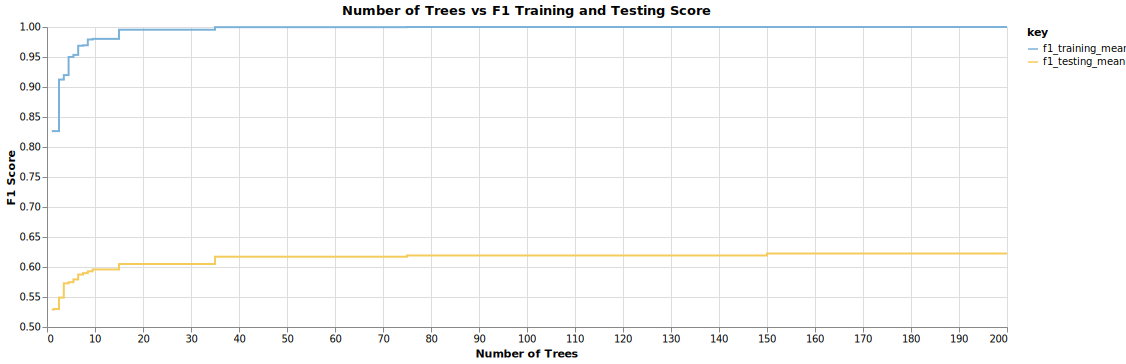

In [24]:
number_of_trees_vs_f1_training_and_testing_score = alt.Chart(pd.DataFrame(combined_results), title="Number of Trees vs F1 Training and Testing Score").transform_fold(
  ['f1_training_mean', 'f1_testing_mean']
).mark_line(interpolate="step").encode(
  x=alt.X('number_of_trees', axis=alt.Axis(title='Number of Trees')),
  y=alt.Y('value:Q', axis=alt.Axis(title='F1 Score'), scale=alt.Scale(domain=(0.5, 1.0))),
  color=alt.Color('key:N', scale=alt.Scale(domain=['f1_training_mean', 'f1_testing_mean'], range=['#7BB2D9', '#F5CB5C'])),
).properties(
  width=960,
  height=300
)

number_of_trees_vs_f1_training_and_testing_score.save('assets/number_of_trees_vs_f1_training_and_testing_score.png', ppi=100)
number_of_trees_vs_f1_training_and_testing_score